In [25]:
from datetime import date, datetime, timedelta
import ndjson
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from top2vec import Top2Vec
from tqdm import tqdm
from wordcloud import WordCloud

sns.set_style('white')
plt.rcParams['font.size'] = 11
plt.rcParams["font.family"] = "sans-serif"

sys.path.append('../../dutch-chronicles/src')
from chronicles.entropies.afa import adaptive_filter

In [3]:
import shutil
import matplotlib

shutil.rmtree(matplotlib.get_cachedir())

## Explore a top2vec model


In [16]:
model = Top2Vec.load('../models/top2vecmodel_230807')

In [17]:
model.get_num_topics()

436

In [18]:
topic_sizes, topics = model.get_topic_sizes()
words, weights, nrs = model.get_topics(reduced=False)
topics = pd.DataFrame({'topic': nrs, 'words': list(words)}, columns=['topic', 'words'])
topics['primitives'] = topic_sizes
#topics.to_csv('../models/230807/230807_topic_words.csv')

In [3]:
df = pd.read_csv('../models/230807/230807_topic_words_theme_2.csv', sep=',', index_col=0)

## Dominant topic per primitive

In [4]:
with open('../models/230807/primitive_topic_top5.ndjson') as fin:
	primtop = ndjson.load(fin)

primtop = pd.DataFrame(primtop)

In [5]:
for i in range(0,5):
    primtop = primtop.merge(df[['topic', 'category']], left_on=f'topic_id_{i}', right_on='topic').sort_values('clean_month').drop('topic', axis=1).rename(columns={'category': f'category_{i}'})

In [6]:
all_rows = []

for i, r in tqdm(primtop.iterrows(), total=primtop.shape[0]):
    d_row = dict(r)
    try:
        d_row['clean_month_dt'] = date.fromisoformat(d_row['clean_month'])
        all_rows.append(d_row)
    except ValueError:
        continue

primtop = pd.DataFrame(all_rows)
primtop.shape

100%|██████████| 84583/84583 [00:12<00:00, 6609.72it/s]


(84548, 19)

In [7]:
primtop['year'] = primtop['clean_month'].str[:4]
primtop['year'] = primtop['year'].astype(int)

In [8]:
df['primitives_corrected'] = primtop.groupby('topic_id_0')['topic_id_0'].count()
df['primitives_corrected_1'] = primtop.groupby('topic_id_1')['topic_id_1'].count()
df['primitives_corrected_2'] = primtop.groupby('topic_id_2')['topic_id_2'].count()

In [9]:
df.groupby('category')['primitives_corrected'].sum().sort_values(ascending=False)

category
1     16491
2      7644
3      7137
4      6400
5      6289
6      5351
7      4744
8      4692
9      4408
10     4296
11     4020
12     3517
13     3395
14     3340
15     2601
16      223
Name: primitives_corrected, dtype: int64

In [2]:
cat_names = ['war and military in the Low Countries', 'administration and local government', 'weather and climate', 'civic life',
                       'life events and social interactions',  'economic activities',  'crime and justice', 'international politics and diplomacy',
                         '(natural) disasters and damage', 'public space, infrastructure and topography', 'public celebrations and festivities',
                          'history and dynasties', 'local and regional politics and upheaval',  'religion and church', 
                        'other languages and dialects',   'patriotic sentiments']

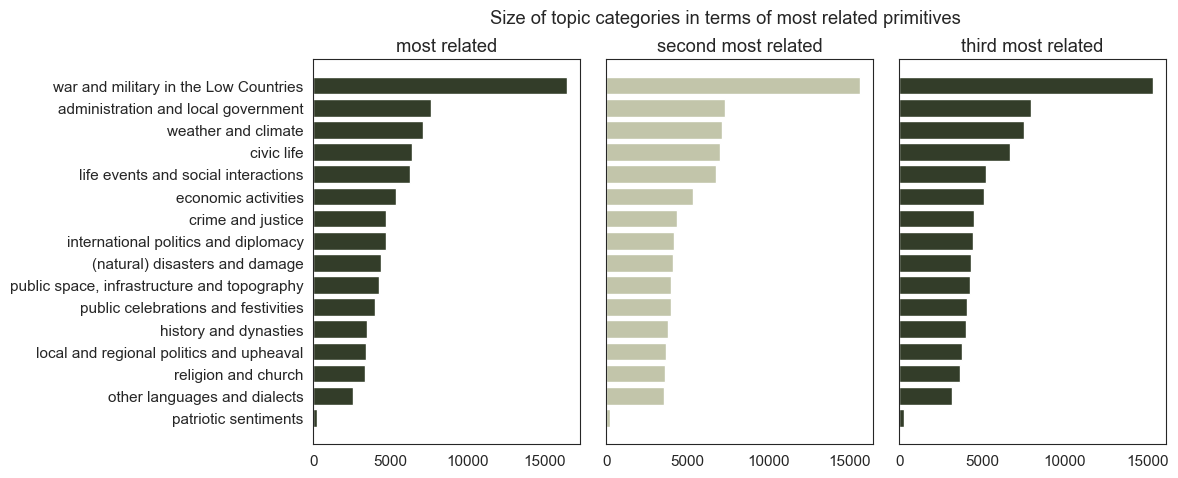

In [10]:
grouped1 = df.groupby('category')['primitives_corrected'].sum().sort_values(ascending=False)
grouped2 = df.groupby('category')['primitives_corrected_1'].sum().sort_values(ascending=False)
grouped3 = df.groupby('category')['primitives_corrected_2'].sum().sort_values(ascending=False)

fig, axs = plt.subplots(1, 3, figsize=(11, 5))
axs = axs.flatten()

axs[0].barh(range(len(grouped1)), grouped1.values[::-1], color='#333D29')
axs[0].set_yticks([])
axs[0].set_yticks(range(len(grouped2)))
axs[0].set_yticklabels(cat_names[::-1], ha='right')
axs[0].set_title('most related')

axs[1].barh(range(len(grouped2)), grouped2.values[::-1], color='#C2C5AA')
axs[1].set_yticks([])
axs[1].set_title('second most related')

axs[2].barh(range(len(grouped3)), grouped3.values[::-1], color='#333D29')
axs[2].set_yticks([])
axs[2].set_title('third most related')

plt.subplots_adjust(wspace=0.1)

plt.suptitle('Size of topic categories in terms of most related primitives')
plt.savefig('../images/topic-categories-3mostrelated.pdf', bbox_inches='tight')


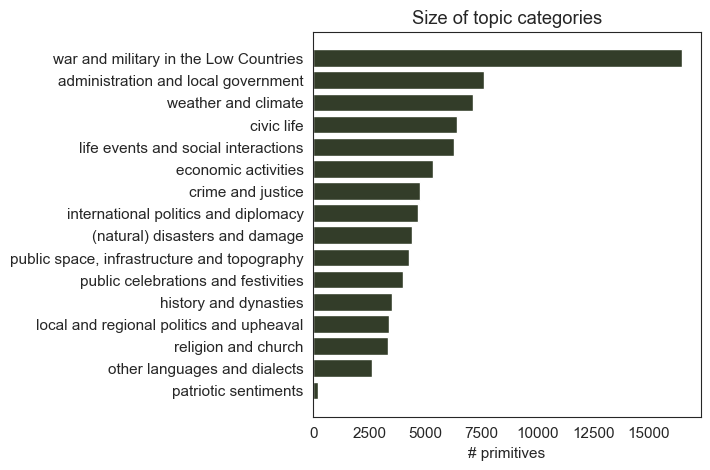

In [11]:
grouped1 = df.groupby('category')['primitives_corrected'].sum().sort_values(ascending=False)

fig, axs = plt.subplots(figsize=(5, 5))

axs.barh(range(len(grouped1)), grouped1.values[::-1], color='#333D29')
axs.set_xlabel('# primitives')
axs.set_yticks(range(len(grouped1)))
axs.set_yticklabels(cat_names[::-1], ha='right')
plt.title('Size of topic categories')

plt.savefig('../images/topic-categories.pdf', bbox_inches='tight')

### Customize wordclouds

In [26]:
# Get the topics, word weights, and topic numbers
topics, word_weights, topic_nums = model.get_topics()

# Create the nested dictionary
nested_dict = {}

# Iterate over the topics, word weights, and topic numbers
for topic_id, topic_words, topic_word_weights in zip(topic_nums, topics, word_weights):
    topic_dict = {}
    # Iterate over the words and their weights in the topic
    for word, weight in zip(topic_words, topic_word_weights):
        topic_dict[word] = weight
    nested_dict[topic_id] = topic_dict

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#333D29', '#C2C5AA'])

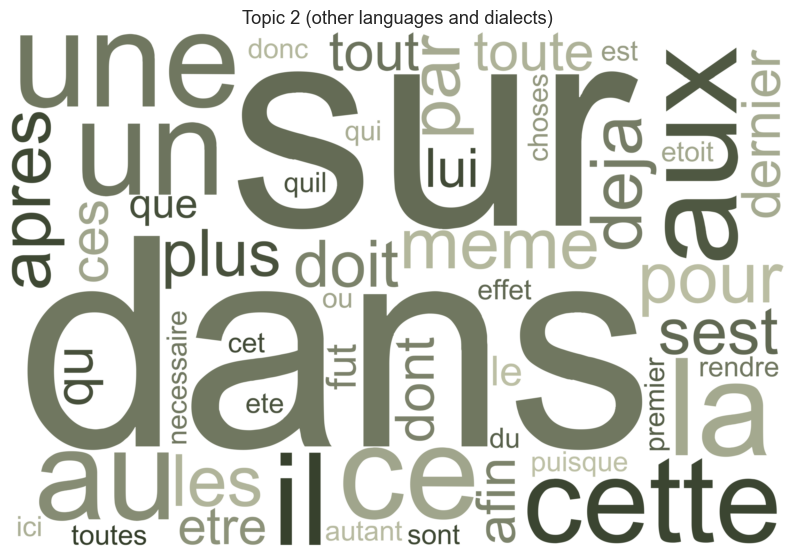

In [27]:
wc = WordCloud(font_path='/Users/alielassche/downloads/arialmt/ARIALMT.ttf', width=3000, height=2000, background_color='white',
                              #min_font_size=15,
                              margin=10,
                              colormap = cmap)
wc.generate_from_frequencies(nested_dict[2])
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc, interpolation='bilinear')
ax.set_title('Topic 2 (other languages and dialects)')
ax.axis("off")
plt.subplots_adjust(top=0.85)
plt.savefig('../images/topic2.pdf', bbox_inches='tight')

### Fluctuation per topic category, with chronicles colored

In [12]:
from matplotlib.colors import ListedColormap

mapping = {1: 'war and military in the Low Countries', 2: 'administration and local government', 3: 'weather and climate', 4: 'civic life',
                       5: 'life events and social interactions', 6: 'economic activities', 7: 'crime and justice', 8: 'international politics and diplomacy',
                        14: 'religion and church', 9: '(natural) disasters and damage', 10: 'public space, infrastructure and topography',
                        12: 'history and dynasties', 13: 'local and regional politics and upheaval', 11: 'public celebrations and festivities',
                        15: 'other languages and dialects', 16: 'patriotic sentiments'}

palette_Paired = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", 'paleturquoise', 'teal', 'palegoldenrod', 'darkkhaki']

cmap = ListedColormap(palette_Paired)

In [8]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [13]:
# Create a set of unique call_nr_clean values
unique_call_nr_clean_values = set(primtop['call_nr_clean'].unique())

# Generate a list of colors from the 'Paired' palette
paired_colors = sns.color_palette("Paired")

# Create a color_dict mapping unique call_nr_clean values to colors
color_dict = {call_nr: paired_colors[i % len(paired_colors)] for i, call_nr in enumerate(unique_call_nr_clean_values)}


### Scatterplot

In [57]:
for i in range (1,17):
    plotted_docs = []
    plt.figure(figsize=(15,7))
    plt.ylim(0, 1)
    plt.xlim([date(1500, 1, 1), date(1860, 12, 31)])  
    for nr in range(0,3):
        category = primtop[primtop[f'category_{nr}'] == i]  
        category = category[~category['doc_id'].isin(plotted_docs)]
        if category.empty:
            continue
        plot = sns.scatterplot(data=category, x='clean_month_dt', y=f'topic_score_{nr}', hue='call_nr_clean', palette=color_dict, alpha=0.7, edgecolor='none')
        plotted_docs.extend(category['doc_id'].values)
    plt.xlabel('year')
    plt.ylabel('cosine similarity')
    plt.title(f'Primitives top3 most related to category {i}: {mapping[i]}')
    plt.legend().remove()
    plt.savefig(f'../images/category{i}_top3.pdf', bbox_inches='tight')
    plt.close()

In [11]:
color_dict['1668_Gent_Bill']

(0.6980392156862745, 0.8745098039215686, 0.5411764705882353)

### histogram, scatter plot, histogram

In [14]:
# Define the start and end dates for the histogram
start_date = datetime(1500, 1, 1)
end_date = datetime(1860, 12, 31)

# Calculate the number of bins needed for 10-year intervals
num_years = (end_date - start_date).days / 365.25  # Approximate number of years
num_bins = int(num_years / 5)  # Number of bins with 10-year intervals

# Generate bin edges for 10-year intervals
bin_edges = [start_date + timedelta(days=(i * 5 * 365.25)) for i in range(num_bins + 1)]

for i in range(1, 17):
    plotted_docs = []
    fig, (ax_line, ax_scatter, ax_hist) = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), gridspec_kw={'width_ratios': [2, 3, 2]})
    ax_scatter.set_ylim(0, 1)
    ax_scatter.set_xlim([date(1500, 1, 1), date(1860, 12, 31)])
    
    for nr in range(3):  # Iterate through 0, 1, 2
        category = primtop[primtop[f'category_{nr}'] == i]  
        category = category[~category['doc_id'].isin(plotted_docs)]
        if category.empty:
            continue
        plot = sns.scatterplot(data=category, x='clean_month_dt', y=f'topic_score_{nr}', hue='call_nr_clean', palette=color_dict, alpha=0.7, edgecolor='none', ax=ax_scatter)
        plotted_docs.extend(category['doc_id'].values)
    
    ax_scatter.set_xlabel('year')
    ax_scatter.set_ylabel('cosine similarity')
    ax_scatter.set_title(f'Cosine similarities of top three most related primitives')
    ax_scatter.legend().remove()
    
    # Histogram abs freq
    category_dates = primtop[(primtop['category_0'] == i) | (primtop['category_1'] == i) | (primtop['category_2'] == i)]
    category_dates1 = primtop[(primtop['category_0'] == i) | (primtop['category_1'] == i) | (primtop['category_2'] == i)]['clean_month_dt']
    category_dates2 = category_dates.groupby('clean_month_dt').size()/primtop.groupby('clean_month_dt').size()
    ax_hist.set_xlim([date(1500, 1, 1), date(1860, 12, 31)])
    ax_hist.hist(category_dates1, bins=bin_edges, color='#333D29')
    ax_hist.set_xlabel('year')
    ax_hist.set_ylabel('absolute frequency')
    ax_hist.set_title('Absolute number of primitives per five years')

    # Histogram rel freq
    category_dates3 = category_dates.groupby('year').size()/primtop.groupby('year').size()
    years = category_dates3.index
    relative_frequencies = category_dates3.values
    num_intervals = len(years) // 5
    grouped_years = [years[i*5:(i+1)*5] for i in range(num_intervals)]
    grouped_frequencies = [np.mean(relative_frequencies[i*5:(i+1)*5]) for i in range(num_intervals)]
    ax_line.set_xlim(1500, 1860)
    ax_line.set_ylim(0,1)
    ax_line.bar([np.mean(interval) for interval in grouped_years], grouped_frequencies, width=5.0, color='#333D29')  # width is set to 5 years
    ax_line.set_xlabel('year')
    ax_line.set_ylabel('relative frequency')
    ax_line.set_title('Relative number of primitives per five years')

    plt.suptitle(f'Category {i}: {mapping[i]}', fontsize=15)
    plt.tight_layout()
    plt.savefig(f'../images/category{i}_scatter_histogram_histogram.pdf', bbox_inches='tight')
    plt.close()

### Histogram with rel freq (and rel freq chronicles)

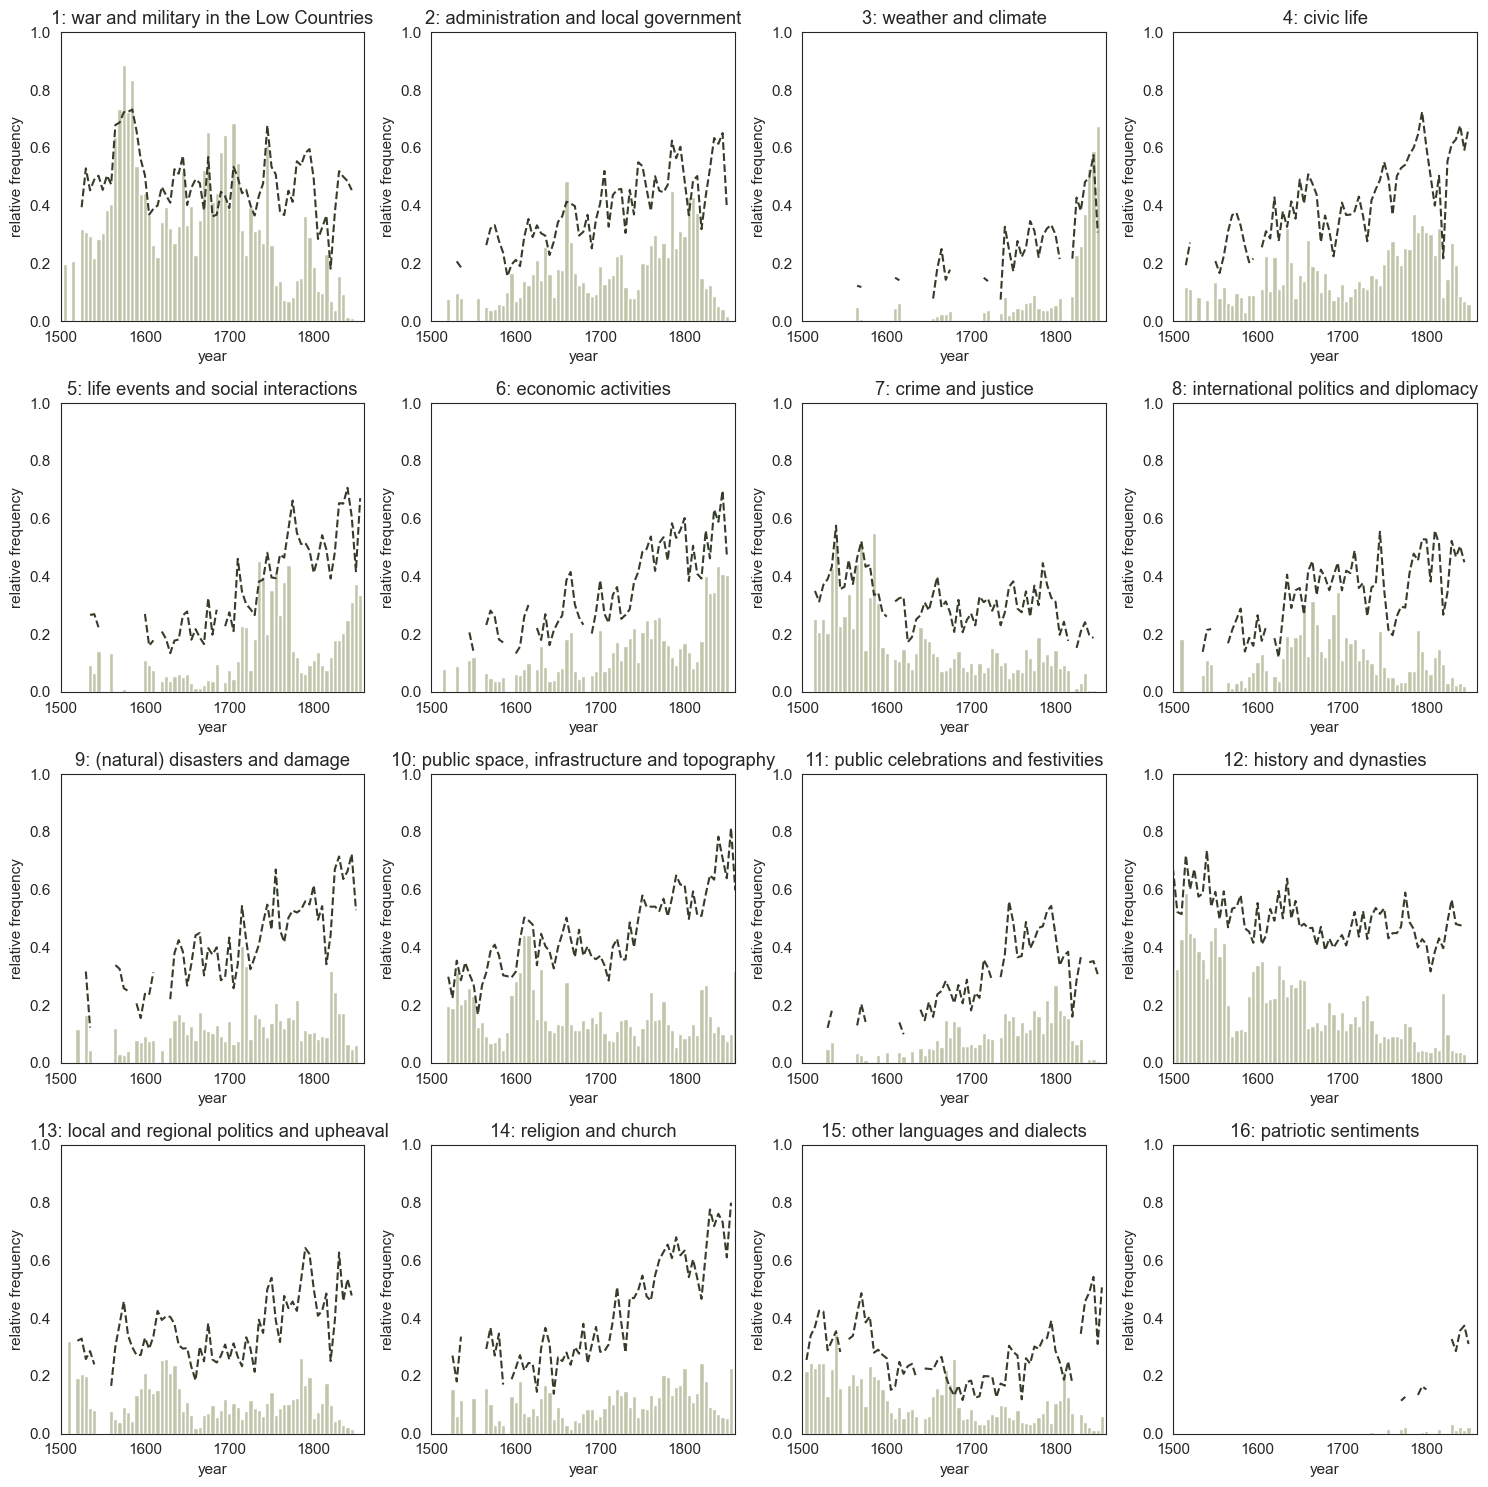

In [28]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15)) #sharex=True, sharey=True
axs = axs.flatten()

for j in range(16):
    i = j+1
    category_dates = primtop[(primtop['category_0'] == i) | (primtop['category_1'] == i) | (primtop['category_2'] == i)]
    category_dates3 = category_dates.groupby('year').size()/primtop.groupby('year').size()
    years = category_dates3.index
    relative_frequencies = category_dates3.values
    num_intervals = len(years) // 5
    grouped_years = [years[i*5:(i+1)*5] for i in range(num_intervals)]
    grouped_frequencies = [np.mean(relative_frequencies[i*5:(i+1)*5]) for i in range(num_intervals)]
    axs[j].set_xlim(1500, 1860)
    axs[j].set_ylim(0,1)
    axs[j].bar([np.mean(interval) for interval in grouped_years], grouped_frequencies, width=5.0, color='#C2C5AA')  # width is set to 5 years

    category_unique_counts = category_dates.groupby('year')['call_nr_clean'].nunique()
    primtop_unique_counts = primtop.groupby('year')['call_nr_clean'].nunique()
    primtop_relative_frequency = category_unique_counts / primtop_unique_counts
    relative_frequencies2 = primtop_relative_frequency.values
    grouped_frequencies2 = [np.mean(relative_frequencies2[i*5:(i+1)*5]) for i in range(num_intervals)]
    x_positions = [np.mean(interval) for interval in grouped_years]
    axs[j].plot(x_positions, grouped_frequencies2, color='#333D29', linestyle='--', label='Unique call_nr_clean relative frequency')

    axs[j].set_xlabel('year')
    axs[j].set_ylabel('relative frequency')
    axs[j].set_title(f'{i}: {mapping[i]}')
    #plt.suptitle('Relative frequencies of primitives in a topic category per five year', fontsize=15)
    plt.tight_layout()
    plt.savefig(f'../images/histograms_new.pdf', bbox_inches='tight')
    #plt.close()

    

### Example grouping and smoothing

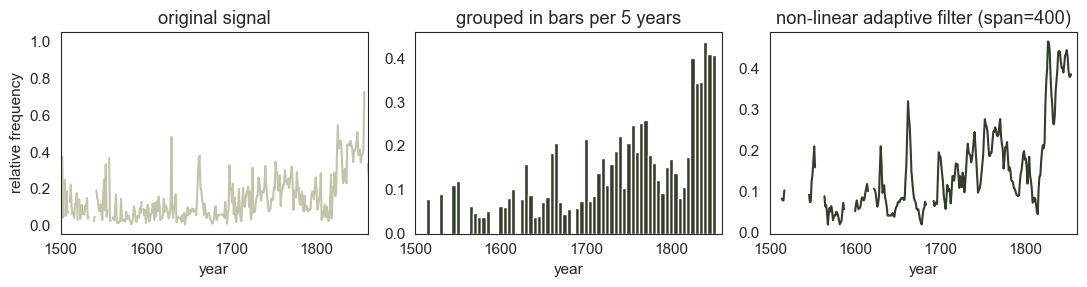

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(11,3))
i = 6

ax[0].set_xlim(1500, 1860)
category_dates = primtop[(primtop['category_0'] == i) | (primtop['category_1'] == i) | (primtop['category_2'] == i)]
category_dates_year = category_dates.groupby('year').size()/primtop.groupby('year').size()
ax[0].plot(category_dates_year.index, category_dates_year.values, color='#C2C5AA')
ax[0].set_ylabel('relative frequency')
ax[0].set_xlabel('year')
ax[0].set_title('original signal')

ax[1].set_xlim(1500, 1860)
years = category_dates_year.index
relative_frequencies = category_dates_year.values
num_intervals = len(years) // 5
grouped_years = [years[j*5:(j+1)*5] for j in range(num_intervals)]
grouped_frequencies = [np.mean(relative_frequencies[j*5:(j+1)*5]) for j in range(num_intervals)]
ax[1].bar([np.mean(interval) for interval in grouped_years], grouped_frequencies, width=5.0, color='#333D29')  # width is set to 5 years
ax[1].set_xlabel('year')
ax[1].set_title('grouped in bars per 5 years')

ax[2].set_xlim(1500, 1860)
ax[2].plot(category_dates_year.index, adaptive_filter(category_dates_year.values, span=400), '#333D29', linestyle='-')
ax[2].set_xlabel('year')
ax[2].set_title('non-linear adaptive filter (span=400)')

plt.tight_layout()
plt.savefig('../images/example_smoothing.pdf', bbox_inches='tight')

### Line plots with multiple categories

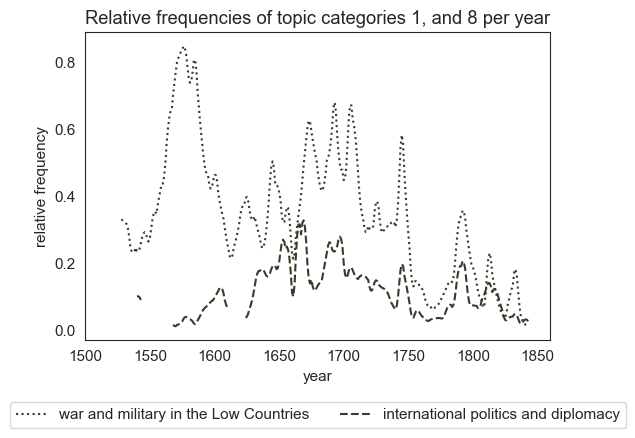

In [50]:
import matplotlib.pyplot as plt
from itertools import cycle

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlim(1500, 1860)
topic_cats = [1, 8]
line_style = [':', '--', '-']
line_style_cycle = cycle(line_style)

for i in topic_cats:
    category_dates = primtop[(primtop['category_0'] == i) | (primtop['category_1'] == i) | (primtop['category_2'] == i)]
    category_dates3 = category_dates.groupby('year').size() / primtop.groupby('year').size()
    
    current_line_style = next(line_style_cycle)
    
    ax.plot(category_dates3.index, adaptive_filter(category_dates3.values, span=300), 
            color='#333D29', linestyle=current_line_style, label=mapping[i])

ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.31))
ax.set_xlabel('year')
ax.set_ylabel('relative frequency')
ax.set_title('Relative frequencies of topic categories 1, and 8 per year')
plt.savefig('../images/relfreq_18_line.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Relative frequencies of topic categories 1 and 8 per year')

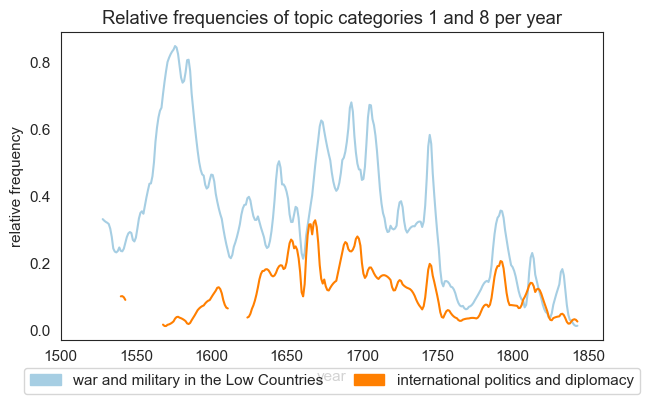

In [12]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(7,4))
ax.set_xlim(1500, 1860)
topic_cats = [1, 8]
legend_patches = []
for i in topic_cats:
    category_dates = primtop[(primtop['category_0'] == i) | (primtop['category_1'] == i) | (primtop['category_2'] == i)]
    category_dates3 = category_dates.groupby('year').size()/primtop.groupby('year').size()
    ax.plot(category_dates3.index, adaptive_filter(category_dates3.values, span=300), 
            color=cmap(i-1), label=mapping[i])
    legend_patches.append(mpatches.Patch(color=cmap(i-1), label=mapping[i]))

ax.legend(handles=legend_patches, bbox_to_anchor=(0.5,-0.2), loc='lower center', ncol=3)  # Set the custom legend using the patches
ax.set_xlabel('year')
ax.set_ylabel('relative frequency')
ax.set_title('Relative frequencies of topic categories 1 and 8 per year')
#plt.savefig('../images/relfreq_18_line.pdf', bbox_inches='tight')

### Select category

In [8]:
crime = primtop[(primtop['category_0'] == 7) | (primtop['category_1'] == 7) | (primtop['category_2'] == 7)]
crime.shape

(10639, 20)

In [10]:
crime.to_csv('crime.csv')

In [17]:
crime = crime[(crime['category_0'] == 7)]
crime = crime[(crime['topic_id_0'] != 34)]
crime.shape

(4054, 20)

In [18]:
crime.head()

,doc_id,clean_month,call_nr_clean,topic_id_0,topic_score_0,topic_id_1,topic_score_1,topic_id_2,topic_score_2,topic_id_3,topic_score_3,topic_id_4,topic_score_4,category_0,category_1,category_2,category_3,category_4,clean_month_dt,year
2,107638,0031-03-01,1666_Gent_Bill,123,0.494697,140,0.482951,296,0.460732,78,0.450490,61,0.427955,7,12,7,12,12,0031-03-01,31
22,68219,0700-09-14,1758_Maas_Anon,88,0.598234,116,0.562962,112,0.514419,347,0.504111,85,0.488791,7,12,12,12,7,0700-09-14,700
32,13949,0775-06-24,1680_Mech_Vale,85,0.350212,352,0.340936,325,0.337306,248,0.333687,28,0.323923,7,1,9,7,7,0775-06-24,775
342,133461,1342-06-12,1792_Brie_Klui,82,0.459406,412,0.360855,172,0.359186,346,0.355225,401,0.311293,7,2,2,7,2,1342-06-12,1342
426,88843,1382-11-15,1699_Bosc_Anon,28,0.377941,235,0.347725,88,0.325837,69,0.325375,8,0.322890,7,7,7,1,10,1382-11-15,1382


In [11]:
with open('../output/primitives_230807/primitives_corrected_monthly_clean.ndjson') as fin:
	prims = ndjson.load(fin)

prims = pd.DataFrame(prims)

In [20]:
crime2 = crime[['doc_id', 'clean_month', 'call_nr_clean', 'topic_id_0', 'topic_score_0']].merge(prims[['id', 'text']], left_on='doc_id', right_on='id')
crime2.head()

,doc_id,clean_month,call_nr_clean,topic_id_0,topic_score_0,id,text
0,107638,0031-03-01,1666_Gent_Bill,123,0.494697,107638,"maene van Maerte , soo wiert Christus vande J..."
1,68219,0700-09-14,1758_Maas_Anon,88,0.598234,68219,Ao. 700. den 14. september word S t . Lambert...
2,13949,0775-06-24,1680_Mech_Vale,85,0.350212,13949,Den H. Rombout besich sijnde met eene kercke t...
3,133461,1342-06-12,1792_Brie_Klui,82,0.459406,133461,Maar indien men nog in het bijsonder wilde vra...
4,88843,1382-11-15,1699_Bosc_Anon,28,0.377941,88843,In den jaere 1382 op den 15 november geviell...


In [21]:
crime2.to_csv('crime2.csv')

### Novelty signal

In [ ]:
df = pd.read_csv('../models/230602/chronicles/1796_Purm_Louw_signal.csv', index_col=0)

all_rows = []

for i, r in df.iterrows():
    d_row = dict(r)
    try:
        d_row['clean_month_dt'] = date.fromisoformat(d_row['clean_month'])
        all_rows.append(d_row)
    except ValueError:
        print(d_row)
df = pd.DataFrame(all_rows)

In [ ]:
from matplotlib.colors import ListedColormap
palette_Paired = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", 'paleturquoise', 'teal', 'palegoldenrod', 'darkkhaki']

color_mapping = {color: mapping[key] for key, color in enumerate(palette_Paired, start=1)}
swapped_color_mapping = {v: k for k, v in color_mapping.items()}

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_6920/4079264668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chronicle['category_0'] = chronicle['category_0'].replace(mapping)


Text(0, 0.5, '$\\mathbb{N}$ovelty')

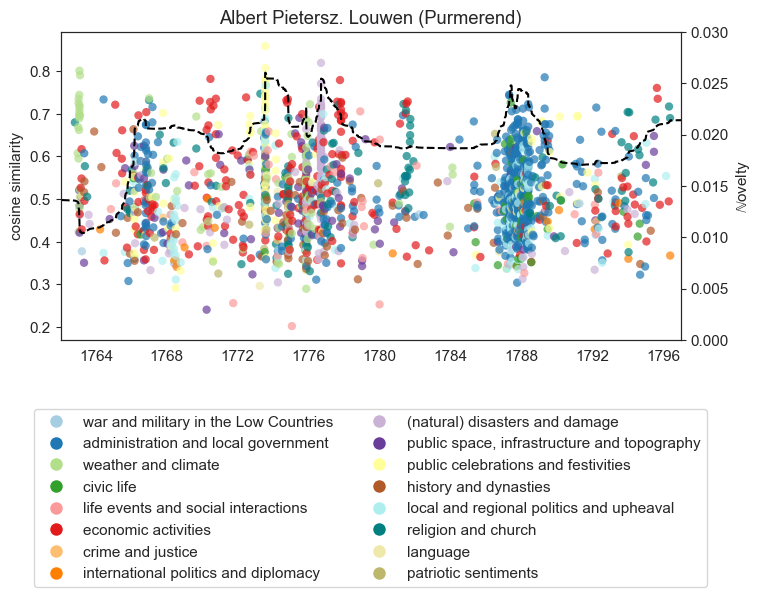

In [ ]:
call_nr = '1796_Purm_Louw'
chronicle = primtop[primtop['call_nr_clean'] == call_nr]
chronicle['category_0'] = chronicle['category_0'].replace(mapping)

legend_order = cat_names
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=swapped_color_mapping[label]) for label in legend_order]

fig, axs = plt.subplots(1, figsize=(8,4))

sns.scatterplot(data=chronicle, x='clean_month_dt', y='topic_score_0', hue='category_0', palette=swapped_color_mapping, alpha=0.7, edgecolor='none', ax=axs)
axs.set_xlim([date(1762, 1, 1), date(1796, 12, 31)])


axs.set_xlabel('')
axs.set_ylabel('cosine similarity')
axs.set_title('Albert Pietersz. Louwen (Purmerend)')
axs.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

ax2 = axs.twinx()
ax2.plot(df['clean_month_dt'], df['novelty_afa'], c='black', linestyle='dashed')
ax2.set_ylim([0, 0.03])
ax2.set_ylabel('$\mathbb{N}$ovelty')
#plt.savefig(f'../images/topic_novelty_{call_nr}.pdf', bbox_inches='tight')